In [1]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

In [24]:
class ActorCritic(nn.Module):
    
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(ActorCritic, self).__init__()
        
        self.critic = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
        self.actor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        value = self.critic(x)
        probs = self.actor(x)
        dist = Categorical(probs)
        return dist, value

In [25]:
class A2C:
    ''' A2C算法
    '''
    def __init__(self,state_dim,action_dim,cfg) -> None:
        self.gamma = cfg.gamma
        self.device = cfg.device
        self.model = ActorCritic(state_dim, action_dim, cfg.hidden_size).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters())

    def compute_returns(self,next_value, rewards, masks):   # mask用来指示是否游戏结束，相当于done
        R = next_value
        returns = []
        for step in reversed(range(len(rewards))):
            R = rewards[step] + self.gamma * R * masks[step]
            returns.insert(0, R)
        return returns

In [26]:
import sys
import os
curr_path = os.path.dirname(os.path.realpath('__file__'))  # 当前文件所在绝对路径
parent_path = os.path.dirname(curr_path)  # 父路径
sys.path.append(parent_path)  # 添加路径到系统路径

import gym
import numpy as np
import torch
import torch.optim as optim
import datetime
from common.multiprocessing_env import SubprocVecEnv
from common.utils import save_results, make_dir, plot_rewards

In [27]:
class A2CConfig:
    def __init__(self) -> None:
        self.algo_name = 'A2C'# 算法名称
        self.env_name = 'CartPole-v1' # 环境名称
        self.n_envs = 8 # 异步的环境数目
        self.gamma = 0.99 # 强化学习中的折扣因子
        self.hidden_dim = 256
        self.lr = 1e-3 # learning rate
        self.max_frames = 30000
        self.n_steps = 5   # what?
        self.device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.save = False

In [28]:
def make_envs(env_name):
    def _thunk():
        env = gym.make(env_name)
        env.seed(2)
        return env
    return _thunk

In [29]:
def test_env(env,model,vis=False):
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(cfg.device)
        dist, _ = model(state)
        next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0])
        state = next_state
        if vis: env.render()
        total_reward += reward
    return total_reward


def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

In [30]:
def train(cfg,envs):
    print('开始训练!')
    print(f'环境：{cfg.env_name}, 算法：{cfg.algo_name}, 设备：{cfg.device}')
    env = gym.make(cfg.env_name) # a single env
    env.seed(10)
    state_dim  = envs.observation_space.shape[0]
    action_dim = envs.action_space.n
    model = ActorCritic(state_dim, action_dim, cfg.hidden_dim).to(cfg.device)
    optimizer = optim.Adam(model.parameters())
    frame_idx    = 0
    test_rewards = []
    test_ma_rewards = []
    state = envs.reset()
    while frame_idx < cfg.max_frames:
        log_probs = []
        values    = []
        rewards   = []
        masks     = []
        entropy = 0
        # rollout trajectory(预演算法)
        for _ in range(cfg.n_steps):
            state = torch.FloatTensor(state).to(cfg.device)
            dist, value = model(state)  # 神经网络预测在当前状态下，总的回报和下一个动作的概率分布
            action = dist.sample()
            next_state, reward, done, _ = envs.step(action.cpu().numpy())
            log_prob = dist.log_prob(action)
            entropy += dist.entropy().mean()
            log_probs.append(log_prob)
            values.append(value)
            rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(cfg.device))
            masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(cfg.device))
            state = next_state
            frame_idx += 1
            if frame_idx % 100 == 0:
                test_reward = np.mean([test_env(env,model) for _ in range(10)])
                print(f"frame_idx:{frame_idx}, test_reward:{test_reward}")
                test_rewards.append(test_reward)
                if test_ma_rewards:
                    test_ma_rewards.append(0.9*test_ma_rewards[-1]+0.1*test_reward)
                else:
                    test_ma_rewards.append(test_reward) 
                # plot(frame_idx, test_rewards)   
        next_state = torch.FloatTensor(next_state).to(cfg.device)
        _, next_value = model(next_state)
        returns = compute_returns(next_value, rewards, masks)
        log_probs = torch.cat(log_probs)
        returns   = torch.cat(returns).detach()  # return是目标
        values    = torch.cat(values)   # value是神经网络（critic）的预测
        advantage = returns - values
        actor_loss  = -(log_probs * advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()
        loss = actor_loss + 0.5 * critic_loss - 0.001 * entropy
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('完成训练！')
    return test_rewards, test_ma_rewards

In [32]:
cfg = A2CConfig()
envs = [make_envs(cfg.env_name) for i in range(cfg.n_envs)]
envs = SubprocVecEnv(envs) 
# envs = make_envs(cfg.env_name)()
rewards, ma_rewards = train(cfg, envs)

开始训练!
环境：CartPole-v1, 算法：A2C, 设备：cuda
frame_idx:100, test_reward:20.7
frame_idx:200, test_reward:20.7
frame_idx:300, test_reward:23.4
frame_idx:400, test_reward:26.9
frame_idx:500, test_reward:16.9
frame_idx:600, test_reward:22.3
frame_idx:700, test_reward:18.0
frame_idx:800, test_reward:19.8
frame_idx:900, test_reward:18.6
frame_idx:1000, test_reward:21.1
frame_idx:1100, test_reward:19.3
frame_idx:1200, test_reward:18.8
frame_idx:1300, test_reward:19.1
frame_idx:1400, test_reward:16.2
frame_idx:1500, test_reward:25.7
frame_idx:1600, test_reward:24.3
frame_idx:1700, test_reward:31.8
frame_idx:1800, test_reward:31.4
frame_idx:1900, test_reward:35.5
frame_idx:2000, test_reward:36.7
frame_idx:2100, test_reward:39.0
frame_idx:2200, test_reward:41.3
frame_idx:2300, test_reward:42.2
frame_idx:2400, test_reward:47.6
frame_idx:2500, test_reward:45.1
frame_idx:2600, test_reward:51.3
frame_idx:2700, test_reward:60.9
frame_idx:2800, test_reward:48.4
frame_idx:2900, test_reward:57.1
frame_idx:3000

frame_idx:23900, test_reward:487.2
frame_idx:24000, test_reward:414.7
frame_idx:24100, test_reward:415.5
frame_idx:24200, test_reward:331.6
frame_idx:24300, test_reward:291.3
frame_idx:24400, test_reward:293.2
frame_idx:24500, test_reward:325.6
frame_idx:24600, test_reward:317.2
frame_idx:24700, test_reward:332.9
frame_idx:24800, test_reward:380.2
frame_idx:24900, test_reward:435.7
frame_idx:25000, test_reward:365.2
frame_idx:25100, test_reward:319.6
frame_idx:25200, test_reward:284.7
frame_idx:25300, test_reward:288.9
frame_idx:25400, test_reward:314.1
frame_idx:25500, test_reward:336.5
frame_idx:25600, test_reward:416.0
frame_idx:25700, test_reward:422.7
frame_idx:25800, test_reward:478.4
frame_idx:25900, test_reward:434.3
frame_idx:26000, test_reward:423.7
frame_idx:26100, test_reward:471.6
frame_idx:26200, test_reward:500.0
frame_idx:26300, test_reward:500.0
frame_idx:26400, test_reward:491.3
frame_idx:26500, test_reward:500.0
frame_idx:26600, test_reward:466.0
frame_idx:26700, tes

In [33]:
# test_env = make_envs(cfg.env_name)()
# print(test_env)

<TimeLimit<OrderEnforcing<CartPoleEnv<CartPole-v1>>>>


In [34]:
# gym.make('CartPole-v1')

<TimeLimit<OrderEnforcing<CartPoleEnv<CartPole-v1>>>>

D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


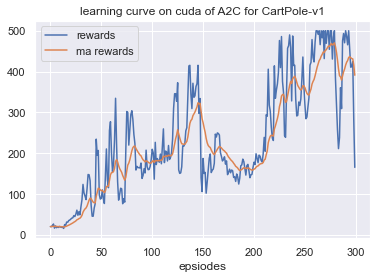

In [35]:
plot_rewards(rewards, ma_rewards, cfg, tag="train") # 画出结果